In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib
import importance_sample_lib as imp_lib
import common_utils 

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=3, max_galaxies=3, num_bands=5, num_images=50, 
                        brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

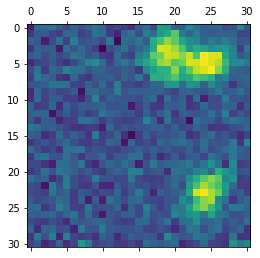

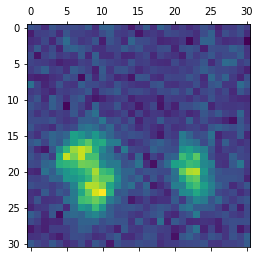

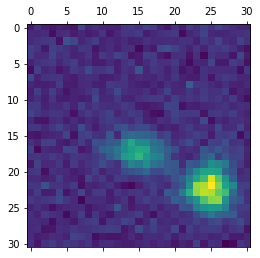

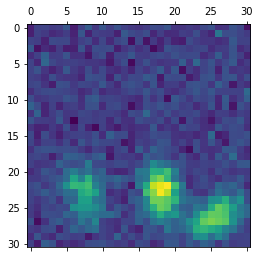

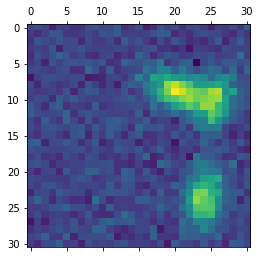

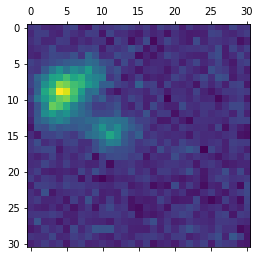

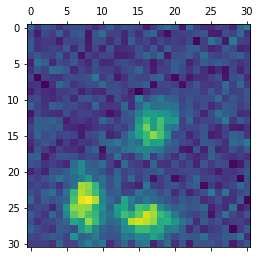

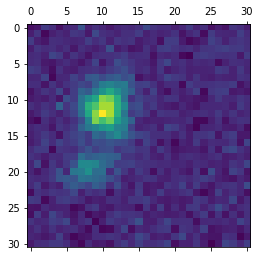

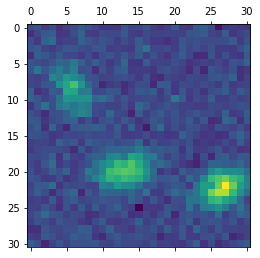

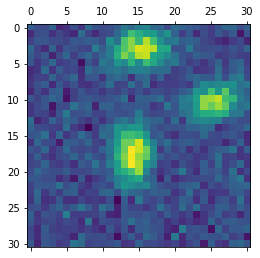

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
imp_weights = imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset=4, prob_off=0)

(array([362.,  64.,  12.,  11.,   7.,   9.,   8.,   3.,   9.,   3.,   4.,
          3.,   6.,   5.,   2.,   1.,   4.,   1.,   2.,   0.,   1.,   2.,
          0.,   3.,   2.,   1.,   1.,   1.,   1.,   2.]),
 array([0.        , 0.00075625, 0.0015125 , 0.00226875, 0.003025  ,
        0.00378125, 0.0045375 , 0.00529376, 0.00605001, 0.00680626,
        0.00756251, 0.00831876, 0.00907501, 0.00983126, 0.01058751,
        0.01134376, 0.01210001, 0.01285626, 0.01361251, 0.01436877,
        0.01512502, 0.01588127, 0.01663752, 0.01739377, 0.01815002,
        0.01890627, 0.01966252, 0.02041877, 0.02117502, 0.02193127,
        0.02268752]),
 <a list of 30 Patch objects>)

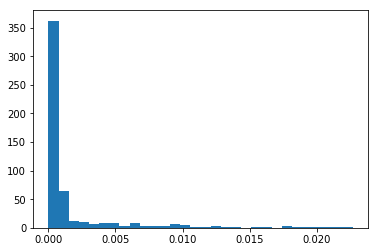

In [8]:
plt.hist(imp_weights[0, :], bins = 30)

# The VAE

In [9]:
one_galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [10]:
# state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
# # state_dict = torch.load("../galaxy_results/test_epoch80.dat", map_location='cpu')

# galaxy_vae.load_state_dict(state_dict, strict=False)

one_galaxy_vae.eval(); 

In [11]:
galaxy_vae = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=one_galaxy_vae)

In [12]:
pixel_probs = galaxy_vae.get_pixel_probs(images_batch1, backgrounds_batch1)

In [13]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [14]:
recon_mean, recon_var, is_on, kl_z = galaxy_vae.sample_conditional_a(
                                            resid_image = images_batch1 - backgrounds_batch1, 
                                            image_so_far = backgrounds_batch1, 
                                            var_so_far = backgrounds_batch1, 
                                            pixel_1d = map_pixel_loc)

In [15]:
map_pixel_loc

tensor([ 459,  444,  436,  430,  459,  117,  443,  170,  404,  334])

In [16]:
is_on

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   4., 403., 122.]),
 array([9.28544847e-17, 2.15575402e-04, 4.31150803e-04, 6.46726205e-04,
        8.62301607e-04, 1.07787701e-03, 1.29345241e-03, 1.50902781e-03,
        1.72460321e-03, 1.94017862e-03, 2.15575402e-03]),
 <a list of 10 Patch objects>)

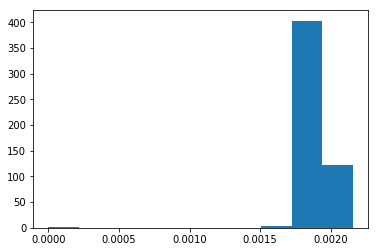

In [17]:
plt.hist(pixel_probs[0, :].detach())

In [18]:
recon_mean.sum()

tensor(730.6387)

In [19]:
recon_var.sum()

tensor(4370.5439)

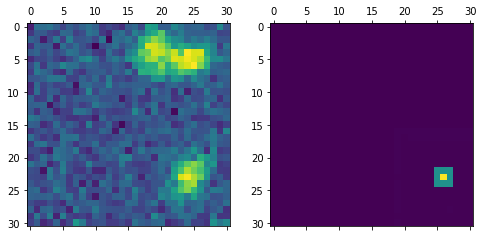

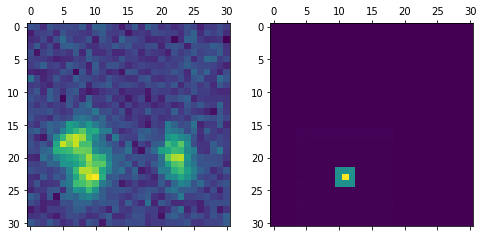

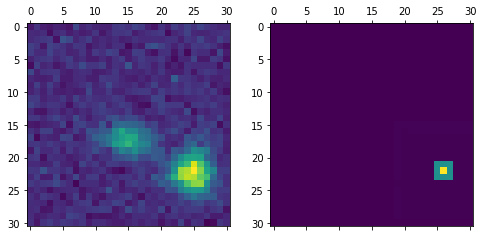

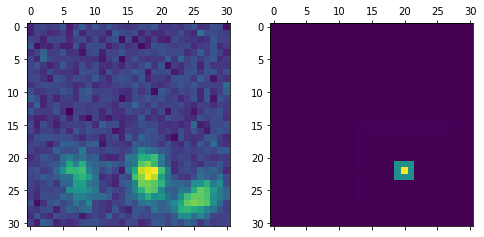

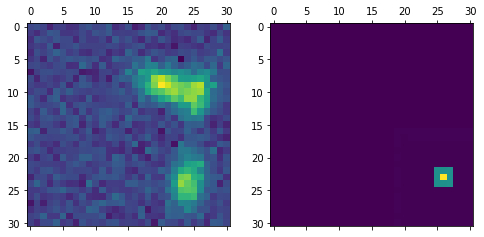

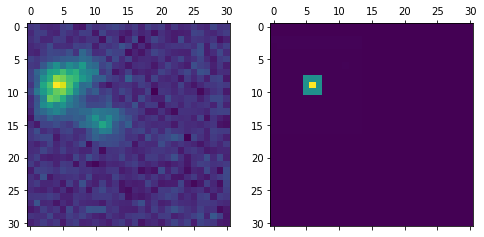

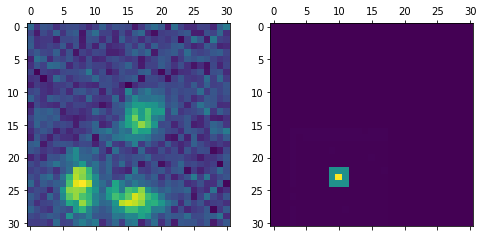

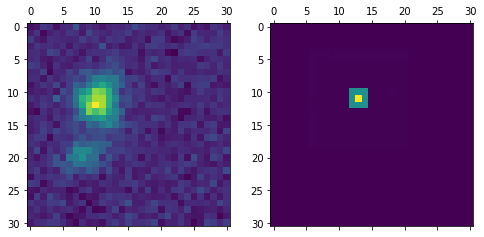

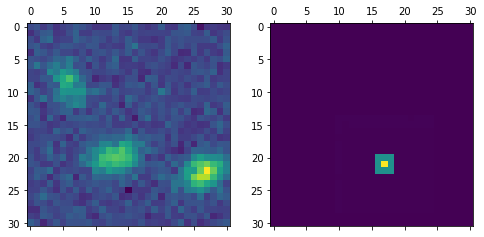

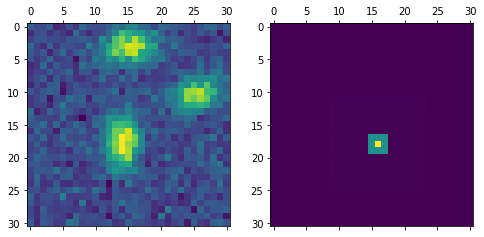

In [20]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


# Experimenting with new importance sampling functions

In [21]:
# function to normalize image
attn_offset = galaxy_vae.attn_offset
# normalized_image = imp_lib.crop_and_normalize_image(images_batch1, attn_offset)

In [22]:
# normalized_image.sum(dim = 1).sum(dim = 1) - 1

In [23]:
# append probability of being off
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1, attn_offset, prob_off)

In [24]:
np.max(np.abs(importance_weights.numpy().sum(1) - 1.0))

7.1525574e-07

In [25]:
print(np.abs(importance_weights.numpy().sum(1) - 1.0))

[2.3841858e-07 5.9604645e-07 1.1920929e-07 1.1920929e-07 7.1525574e-07
 3.5762787e-07 3.5762787e-07 1.7881393e-07 1.1920929e-07 0.0000000e+00]


In [26]:
assert np.max(np.abs(importance_weights[:, -1].numpy() - prob_off.numpy().squeeze())) < 1e-16
assert np.max(np.abs(importance_weights.numpy().sum(1) - 1.0)) < 1e-6

In [27]:
# visually check importance weights: 

In [28]:
prob_off = torch.zeros((images_batch1.shape[0], 1)) # pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset, prob_off)

In [29]:
which_n = 1
image_sampled = torch.zeros((side_len, side_len))
for i in range(10000): 
    z_sample = common_utils.sample_class_weights(importance_weights)
    pixel_2d = galaxy_vae.one_galaxy_vae.pixel_1d_to_2d(z_sample)
    image_sampled[pixel_2d[which_n, 0], pixel_2d[which_n, 1]] += 1

(array([377.,  40.,  28.,  22.,  17.,  16.,  11.,   8.,   8.,   3.]),
 array([0.        , 0.00146697, 0.00293393, 0.0044009 , 0.00586787,
        0.00733484, 0.0088018 , 0.01026877, 0.01173574, 0.01320271,
        0.01466967]),
 <a list of 10 Patch objects>)

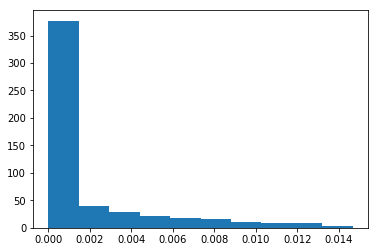

In [30]:
plt.hist(importance_weights[which_n, :])

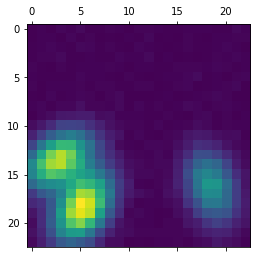

In [31]:
imp_weights_grid = importance_weights[:, 0:-1].view(images_batch1.shape[0], 23, 23)
plt.matshow(imp_weights_grid.detach()[which_n, :, :])

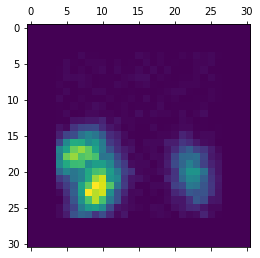

In [32]:
plt.matshow(image_sampled)

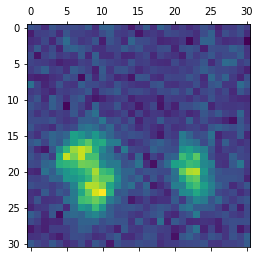

In [33]:
plt.matshow(images_batch1[which_n, 0, :, :])

In [34]:
# check optimizer goes through

In [35]:
optimizer = optim.Adam(galaxy_vae.parameters(), lr=0.01, weight_decay=1e-6)
optimizer.zero_grad()

In [36]:
pm_loss, neg_elbo, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

tensor([ 0.2165,  0.4133,  0.5123,  0.0689,  0.3762,  0.0483,  0.2595,
         0.1930,  5.0217,  0.0557])
tensor([ 0.0484,  0.0547,  0.2408,  0.0398,  0.1169,  0.0022,  0.0376,
         0.0373,  1.6721,  0.0140])
torch.Size([10])
torch.Size([10])
torch.Size([10])


In [43]:
# check params
all_params = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params = torch.cat([params, all_params])

In [44]:
pm_loss

tensor(1.00000e+06 *
       -2.0484)

In [45]:
pm_loss.backward()

In [46]:
optimizer.step()

In [48]:
_, neg_elbo2, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

tensor([ 0.4240,  0.3082,  0.1432,  0.0999,  0.2894,  1.2969,  0.1501,
         1.9282,  3.4704,  0.1338])
tensor([  0.1565,   0.0259,   0.0131,   0.9281,   0.0955,   0.2401,
          0.0417,  25.1554,   0.7003,   0.0717])
torch.Size([10])
torch.Size([10])
torch.Size([10])


In [49]:
neg_elbo2

tensor(1.00000e+05 *
       1.3105)

In [50]:
# check params
all_params2 = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params2 = torch.cat([params, all_params2])

In [51]:
torch.max(all_params2 - all_params)

tensor(1.00000e-02 *
       1.0000)

(array([1043184.,    4703.,    2140.,    1662.,  132682.,  148135.,
           1848.,    1926.,    4020., 1058221.]),
 array([-0.01000001, -0.008     , -0.006     , -0.004     , -0.002     ,
         0.        ,  0.002     ,  0.004     ,  0.006     ,  0.008     ,
         0.01000001]),
 <a list of 10 Patch objects>)

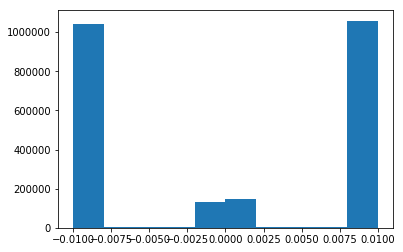

In [52]:
plt.hist((all_params2 - all_params).detach())

In [53]:
# Check train module

In [54]:
# train_module(vae, train_loader, test_loader, epochs,
#                         use_baseline = True,
#                         use_importance_sample = True,
#                         lr = 1e-4, weight_decay = 1e-6,
#                         save_every = 10,
#                         filename = './galaxy_vae_params',
#                         seed = 245345)

In [55]:
imp_lib.train_module(galaxy_vae, train_loader, test_loader, 
                        epochs = 12, save_every = 2, 
                        use_baseline = True, 
                        use_importance_sample = True, 
                        max_detections = 2, 
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

tensor([ 0.1493,  0.7049,  0.0847,  0.1098,  0.1595,  0.2190,  0.1553,
         2.3381,  0.2460,  0.5626])
tensor([ 0.0423,  0.0540,  0.0071,  0.0774,  0.0198,  0.0466,  0.0604,
         3.8248,  0.0477,  0.0873])
torch.Size([10])
torch.Size([10])
torch.Size([10])
tensor([ 0.2009,  0.1695,  1.8080,  0.2387,  0.1279,  0.4493,  0.1097,
         2.8927,  0.1629,  1.0801])
tensor([ 0.0276,  0.4004,  0.1261,  0.1108,  0.1581,  2.0201,  0.0121,
         0.5277,  0.4954,  0.3818])
torch.Size([10])
torch.Size([10])
torch.Size([10])
tensor([ 0.1388,  0.0628,  0.0746,  0.2173,  0.1952,  0.1861,  0.6309,
         0.0865,  1.4897,  0.6090])
tensor([ 0.0398,  0.0234,  0.0045,  0.1199,  0.4691,  0.0332,  0.2023,
         0.0158,  0.5481,  0.8604])
torch.Size([10])
torch.Size([10])
torch.Size([10])
tensor([ 0.1679,  0.1617,  0.0746,  0.1762,  0.5234,  0.1995,  3.2753,
         0.1235,  0.1474,  4.9219])
tensor([ 0.0794,  0.4628,  0.0447,  0.0283,  0.3503,  0.1150,  0.3367,
         0.7900,  0.0219,  

In [56]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [57]:
galaxy_vae_reload

OneGalaxyVAE(
  (attn_enc): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(10, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
      (8): Softmax()
    )
    (detect_none): Sequential(
      (0): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (8): Conv2d(16, 16, kernel_size=(3, 3), stri

In [58]:
np.load('./test_test_losses_array.npy')

array([153173.62, 234323.7 , 253783.03, 402490.3 , 228250.16, 258009.84],
      dtype=float32)